In [5]:
import cPickle as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora, models
#import nltk

%matplotlib inline

In [6]:
# NWORDS_SHOWN = 15# Number of words per topic to extract
# SELECTED = [1,2,4,6,8,11,14,25]#Numbers of the topics that I will include in the table

In [7]:
def get_topics(bid, bid_df):
    """Given arguments: a bid (doctor ID) and the bid_df (dataframe), 
    Extract and return a sorted series for one bid with the top 10 topics
    Eventually, extend this to include the doctor's name. """
    
    all_topics = bid_df.ix[bid,:]#type Series
    all_topics.sort(axis=0, ascending=False)
    doc_topics = all_topics[:10]
    
    return doc_topics

In [8]:
def convert_rgb(org_color):   
    """org_color is type string: '174.199.232'
    # Original values are scaled 1-255
    # rgb_color is type tuple
    # Final color is scaled 0-1: (0.643,0.416,0.894)"""
    
    str_vec = org_color.strip().split('.')#type list - of strings
    num_vec = [float(s) for s in str_vec]#type list - of floats
    rgb_scale = [(n/255) for n in num_vec]#type list - of scaled floats
    
    # Note: Tried a regular expression...
    # It doesn't work - e.g.,:  t2 = [t[i] for i in t]
    # TypeError: tuple indices must be integers, not float
    rgb_tuple = (rgb_scale[0],rgb_scale[1],rgb_scale[2])
    return rgb_tuple

In [9]:
def tableau10():
    """ returns a dict with color names as keys and converted rgb tuples as values
    #http://tableaufriction.blogspot.ro/2012/11/finally-you-can-use-tableau-data-colors.html
    #References convert_rgb()"""

    tableau={}#dict
    color_key = [
    'dark_grey','med_grey','med2_grey','med3_grey','med4_grey','light_grey',
    'blue','orange','green','red','purple',
    'turq','puke','med_puke','light_puke',
    'brown','lav',
    'dark_red','bright_red','fushia_red','salmon','blue_red','light_red',
    'cool_blue','purp_blue','med_blue','med2_blue','med3_blue',
    'lav_blue','sky_blue','light_cool_blue']
    color_str = [
    '50.50.50','75.75.75','100.100.100','125.125.125','150.150.150','200.200.200',
    '31.119.180','255.127.14','44.160.44','214.39.40','148.103.189',
    '23.190.207','188.189.34','205.204.93','219.219.141',
    '140.86.75','227.119.194',
    '177.3.24','240.39.32','189.10.54','242.108.100','177.3.74','254.69.70',
    '44.105.176','144.158.206','107.163.214','137.183.214','95.158.209',
    '181.200.226','177.213.240','94.155.225']
    
    for idx in range(0,len(color_key)):
        #print(color_str[idx])
        tup = convert_rgb(color_str[idx])
        #tableau[color_key[idx]] = color_str[idx]
        tableau[color_key[idx]] = tup
    
    #For Displaying/debugging
    #print(tableau.items())
    #print(tableau['dark_grey'])#access by color-name
    return tableau

In [10]:
class colors:
    """ Class that defines colors in a palette for a bar graph"""
    t = tableau10()#color settings

    c = [ t['purple'],t['cool_blue'],t['light_cool_blue'],t['turq'],t['green'],
         t['med_puke'],t['orange'],t['salmon'],t['light_red'],t['fushia_red'] ]#10 bar colors
    
    err = [ t['med2_grey'],t['med2_grey'] ]#error bar color
    edge = [ t['med2_grey'] ]
    
    xlb = t['dark_grey']; ylb = t['dark_grey']#labels
    xtk = t['med3_grey']; ytk = t['med3_grey']#ticks
    ytl = t['med3_grey']#ticklines
    leg = t['med3_grey']#legend box
    box = t['med4_grey']

In [11]:
def save_fig(name, fig):
    #path = 'Users/kaschbacher/insightproject/yelp/website/app/static/img/'
    # path above doesn't work maybe because jupter is running inside yelp/git-yelp and this path is outside that
    path=''
    filename = name+'.png'
    fig.savefig((path+filename))
    

In [12]:
def dr_bar_graph(topics, c, name):
    """Make a bar graph for a given doctor
    Argument: topics = Series of 10 topic weights to graph. name = doctor's name as title.
              topics series indices correspond to topic numbers = x-axis labels
    Returns: figure object with the bar graph
    """
    
    ind = np.arange(len(topics))#This may throw error if emmeans has only one DV
    width = 0.75
    
    # Instatiate objects
    fig, ax = plt.subplots()
    
    # Plot data as bars
    rects1 = ax.bar(ind, topics, width, color=c.c,edgecolor=c.edge)
    #print(plt.getp(rects1))# A way to inspect the properties of an artist object
    
    # Format axes labels, ticks, and lines
    plt.rc('axes',ec=c.box)
    ax.set_xlabel('Topic Number', fontsize=14, color=c.xlb)
    ax.set_ylabel('Topic Distribution', fontsize=14, color=c.ylb)
    #ax.set_title(name, fontsize=16)
    
    ax.set_xticks(ind+(width/2))
    ax.set_xticklabels(topics.index,fontsize=11, color=c.xtk)
    plt.setp([ax.get_yticklabels()],color=c.ytk)
    
    plt.setp([ax.get_xticklines()], visible=False)
    plt.setp([ax.get_yticklines()], color=c.ytl)
    
    # Limits of y axis
    plt.ylim([0, np.max(topics)*1.2])#good to start with
    
    ax.margins(0.05)
    plt.show()
    
    return fig

   BID                            yelp_id                              names
0  303      james-l-chen-md-san-francisco      james l chen md san francisco
1  304    elly-s-laroque-md-san-francisco    elly s laroque md san francisco
2  305  nicholas-colyvas-md-san-francisco  nicholas colyvas md san francisco
3  306     c-benjamin-ma-md-san-francisco     c benjamin ma md san francisco
4  307   irene-minkowsky-md-san-francisco   irene minkowsky md san francisco
     0   1   2   3   4   5   6   7   8   9     ...           20        21  22  \
BID                                            ...                              
590   0   0   0   0   0   0   0   0   0   0    ...     0.000000  0.000000   0   
600   0   0   0   0   0   0   0   0   0   0    ...     0.000000  0.000000   0   
603   0   0   0   0   0   0   0   0   0   0    ...     0.000000  0.493556   0   
607   0   0   0   0   0   0   0   0   0   0    ...     0.326478  0.000000   0   
611   0   0   0   0   0   0   0   0   0   0    ...  

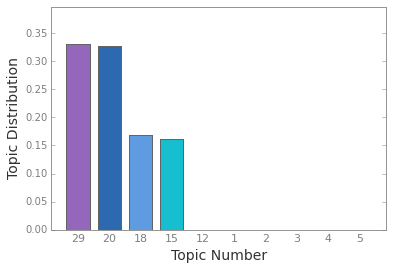

In [15]:
def main():
    
    #doc_name passed to views_py by input.html
    doc_bid = 607# eventually, either bid_df will contain name, or name and bid will be passed from input.html
    doc_name = "bid"+str(doc_bid)
    
    #Load Data
    #lda = pickle.load(open('lda_ortho_30t_filter.p','rb'))#Made in LDA_Doctor_Topics
    bid_df = pickle.load(open('bid_tmeans.p', 'rb'))#Made in LDA_Doctor_Topics
    topic_word_df = pickle.load(open('topic_word_df.p','rb'))#Made in Get_words
    names_df = pd.read_pickle('names_df.p')
    
    # Extract the top 10 topics for given doctor
    doc_topics = get_topics(doc_bid, bid_df)#returns series of 10 topics in sorted order
    selected = doc_topics.index
    #print doc_topics
    
    # Make a bar graph
    palette = colors() 
    fig = dr_bar_graph(doc_topics, palette, doc_name)
    save_fig(doc_name, fig)
    
    # Make a Topic-Word Table
    table = topic_word_df.loc[selected,:]
    words_lol = table.values.tolist()
    
    for words in words_lol:
         for word in words:
                pass
                #print word
    #print table
    
if __name__=="__main__":
    main()
 